In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle

# Optimization
from functools import partial
from itertools import chain

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(1,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]

# Continuous Item Memory Generators

In [4]:
class LinearCIM():
    def __init__(self, sparsity=0.3, dim=10000):
        self.sparsity = sparsity
        self.dim = dim
    
    def modify_specs(self, sparsity=None, dim=None):
        self.sparsity = sparsity if sparsity else self.sparsity
        self.dim = dim if dim else self.dim

    def generate(self, keys):
        seed = SparseHDC.generate_sparse_HV(sparsity=self.sparsity, dim=self.dim)
        tracker = pd.Series(np.copy(seed))
        bit_step = int(np.sum(seed)/(len(keys)-1))
        hvs = [seed]

        for i in range(1,len(keys)):
            next_hv = np.copy(hvs[i-1])

            # TURN OFF K bits
            turnoff_index = random.sample(list(tracker[tracker==1].index), bit_step)
            tracker[turnoff_index]=-1 #Update to cannot be touched
            next_hv[turnoff_index]=0 #Turn them off from previous hv

            # TURN ON K bits
            turnon_index = random.sample(list(tracker[tracker==0].index), bit_step)
            tracker[turnon_index]=-1 #Update to cannot be touched
            next_hv[turnon_index]=1 #Turn them on

            hvs.append(next_hv)
            
        return dict(zip(keys,hvs))

# Binders

In [5]:
# Binding Method
    
class MBitSignatureBinder(): #(Imani et.al. 2019)
    def __init__(self, base_hv_count=617, level_hv_count=10, range_multiplier=10):
        self.base_shifts = random.sample(range(0,base_hv_count*range_multiplier), base_hv_count)
        self.level_shifts = random.sample(range(0,level_hv_count*range_multiplier), level_hv_count)
        
    def bind(self, base, base_no, level, level_no):
        return ((SparseHDC.cyclic_shift(base, self.base_shifts[base_no]) + SparseHDC.cyclic_shift(level, self.level_shifts[level_no]))>1).astype(int)

In [6]:
# MBitSignatureBinder Test

mbit = MBitSignatureBinder(617, 10, range_multiplier=1)
base = SparseHDC.generate_sparse_HV(sparsity=0.1)
level = SparseHDC.generate_sparse_HV(sparsity=0.1)
base_shifted = np.roll(base,mbit.base_shifts[0])
level_shifted =  np.roll(level,mbit.level_shifts[0])
expected_bind = ((base_shifted + level_shifted)>1).astype(int)
print("Number of ones: {}".format(np.sum(expected_bind)))
print("Correctness: {}".format(np.sum(mbit.bind(base,0,level,0)==expected_bind)==10000))

Number of ones: 105
Correctness: True


# Sparsifiers

In [7]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.threshold = int(percent_max_val*max_val)
    
    def sparsify(self, hv, threshold=None):
        self.threshold = threshold if threshold else self.threshold
        return np.array((hv>self.threshold)).astype(np.int)

# Encoding Algorithms

## 1. Sparse Feature Encoder
   based on feature encoding with the operation $$X = [B_1*L_1 + B_2*L_2...]$$

   ### Constructor Parameters: <br />
   <ul>
       <li><b>cim_generator</b> : Algorithm to generator the continuous item memory level vectors <br /></li>
       <li><b>binder</b> : Algorithm for binding two vectors <br /></li>
       <li><b>sparsifier</b> : Algorithm to convert accumulation hypervector back to sparse vector <br /></li>
   </ul>
   <br />
   Default parameters are set for the ISOLET dataset <br />
   <br />

In [8]:
# ENCODING ALGORITHMS

class Sparse_FeatureEncoder():
    def __init__(self, cim_generator, binder, sparsifier, sparsity=0.3, feature_count=617, qlevel_count=10, dim=10000):
        self.cim = cim_generator
        self.binder = binder
        self.sparsifier = sparsifier
        self.feature_count = feature_count
        self.qlevel_count = qlevel_count
        self.sparsity = sparsity
        self.dim = dim    
        self.base_hvs = SparseHDC.generate_sparse_HVs(count=feature_count, sparsity=sparsity, dim=dim)
        
        #Setup functions
        self.qlevels = self.quantization_levels()
        self.setup_CIM()
    
    def change_sparsity(sparsity=0.3):
        pass

    def encode(self, features, return_accumulated=False):
        if len(features)!=self.feature_count:
            return "Invalid number of features"

        #Quantize
        quantized = np.vectorize(self.quantize)(features)
        level_nos = [self.qlevels.index(q) for q in quantized]
        
        #Map to CIM
        mapped_to_hvs = [self.cim[v] for v in quantized]
        
         # Bind and Accumulate (Summation of Base*Level)
        accumulated_hv = np.repeat(0,self.dim)
        for i in range(0,self.feature_count):
             accumulated_hv += self.binder.bind(
                                    base=self.base_hvs[i],
                                    base_no=i, 
                                    level=mapped_to_hvs[i],
                                    level_no=level_nos[i]
                                )
        
        thresholded_hv = self.sparsifier.sparsify(accumulated_hv)

        return accumulated_hv if return_accumulated else thresholded_hv
    
    # ENCAPSULATED DEPENDENCY METHODS

    def setup_CIM(self):
        self.cim = self.cim.generate(self.qlevels)

    # ENCODING HELPERS
    def quantization_levels(self, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (self.qlevel_count-1)
        return list(np.arange(min_val, max_val+step, step).round(precision))
            
    def quantize(self, value):
        return min(self.qlevels, key=lambda x:abs(x-value))

In [9]:
def test_basehv_distances(encoder):
    dists = []

    for i in range(0,len(encoder.base_hvs)):
        for j in range(i+1,len(encoder.base_hvs)):
                dists.append(SparseHDC.dot(encoder.base_hvs[i], encoder.base_hvs[j]))

    plt.plot(np.array(dists)/int(encoder.sparsity*encoder.dim))
    plt.title("Pairwise Distance Between Base HVs")
    plt.ylim(0,1)

In [10]:
# END-TO-END

class HDC_Classifier():
    def __init__(self, encoder, ACC_THR = 125, training_data=ISOLET()):
        self.encoder = encoder
        self.data = training_data
        self.class_hvs = {}
        self.training_encoded = {}
        self.test_encoded = None
        self.ACC_THR = ACC_THR

    def train(self, save_encodes=True):      
        # Group rows by class
        classes = self.train_y().unique()
        class_rows = {}
        class_hvs = {}
        
        # Rows in each class
        class_indexes = {}
        for class_ in classes:
            class_indexes[class_] = list(self.train_y()[self.train_y()==class_].index)

        for class_ in classes:
            class_rows[class_] = np.array(list(self.train_X().loc[class_indexes[class_]].itertuples(index=False, name=None)))
        
        encoded = {}
        for class_ in classes:
            print("Encoding... {}% ".format(round(100*class_/classes[-1],2)))
            encoded[class_] = pd.Series(map(self.encoder.encode, class_rows[class_]))
        if save_encodes:
            self.training_encoded = encoded
        
        accumulated = np.array([np.sum(encoded[class_]) for class_ in classes])
        class_sparsifier = ThresholdingSparsifier(percent_max_val = self.ACC_THR/240, max_val=240)
        thresholded = pd.Series(map(class_sparsifier.sparsify, accumulated))
        thresholded.index = range(1,27)
        
        self.class_hvs = dict(thresholded)
        
        return "Done"
    
    def test(self):
        encoded_test = pd.Series(map(self.encoder.encode, np.array(self.test_X())))
        predictions = pd.Series(map(self.query, encoded_test))
        return np.sum(predictions == self.test_y())/len(self.test_y())

    # HELPER FUNCTIONS
    def query(self, query_hv):
        d = dict([[class_, SparseHDC.dot(class_hv, query_hv)] for class_,class_hv in self.class_hvs.items()])
        return max(d, key=d.get)
    
    def train_X(self):
        return self.data.train_X
    
    def train_y(self):
        return self.data.train_y
    
    def test_X(self):
        return self.data.test_X
    
    def test_y(self):
        return self.data.test_y

In [11]:
### OPTIMIZATION RESULTS
#Encoding from 168ms to 77.2ms @10k bits
#Training time reduced from 80mins to 9mins

#-68ms for binding <br>
# ~-2ms for removing from function

# 6.0ms for quantization

# 0.5ms mapping

# 0.2ms for sparsification
#   ~-0.5ms by removing from function

# MODEL DEVELOPMENT

### CONVERT NEXT THREE CELLS TO CODE AND RUN AS NEEDED

In [12]:
# RUN THIS ONCE

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))
    
# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

In [13]:
# UTILITY FUNCTIONS

def setup_feature_encoder(dim=10000, sparsity=0.3, percent_max_val=0.45, M=10):
    cim_generator = LinearCIM(sparsity=sparsity, dim=dim)
    binder = MBitSignatureBinder(level_hv_count=M)
    sparsifier = ThresholdingSparsifier(percent_max_val=percent_max_val)
    return Sparse_FeatureEncoder(
                cim_generator = cim_generator,
                binder = binder,
                sparsifier = sparsifier,
                sparsity = sparsity,
                dim = dim,
                qlevel_count = M
            )

def interclass_dot_product(class_hvs):
    dot_products = []
    classes = list(class_hvs.keys())
    for i in range(0, len(classes)):
        for j in range(i+1, len(classes)):
                dot_products.append( SparseHDC.dot(class_hvs[classes[i]], class_hvs[classes[j]]) )

    print("Mean dot {}".format(np.average(np.array(dot_products))))
    plt.plot(dot_products)
    plt.title("Interclass Dot Products")

def plot_encode_sparsities(encode, target_sparsity=0.3, app_title=""):
    classes = list(encode.keys())
    dim = len(encode[classes[0]][0])
    no_of_ones = []
    
    for class_ in classes:
        for row in encode[class_]:
            no_of_ones.append(np.sum(row))
            
    plt.plot(np.array(no_of_ones)/dim)
    plt.title("Sparsity of Encoded Vectors {}".format(app_title))
    plt.xlabel('sample no.')
    plt.ylabel('sparsity')

In [14]:
# CHANGE PARAMETERS HERE

dim = 10000
sparsity = 0.05
ENC_THR = 15
ACC_THR = 105
M = 2

feature_encoder = setup_feature_encoder(dim=dim, sparsity=sparsity, percent_max_val=ENC_THR/617, M=M)
classifier = HDC_Classifier(encoder=feature_encoder, ACC_THR=ACC_THR)
classifier.train()
# # Save models in the format "HDC_Classifier_<CIM Method>_<Binding Method>_<Sparsifying Method>_S<sparsity>_D<dimensions>.pkl"
# # e.g. HDCModels.save_model(model=classifier, filename='HDC_Classifier_IM_BIND_TRESH_S0.x_Dxxxxx.pkl')
# HDCModels.save_model(model=classifier, filename='HDC_Classifier_LCIM_MBIT_TRESH_S0.3_D10000.pkl')

Encoding... 3.85% 
Encoding... 7.69% 
Encoding... 11.54% 
Encoding... 15.38% 
Encoding... 19.23% 
Encoding... 23.08% 
Encoding... 26.92% 
Encoding... 30.77% 
Encoding... 34.62% 
Encoding... 38.46% 
Encoding... 42.31% 
Encoding... 46.15% 
Encoding... 50.0% 
Encoding... 53.85% 
Encoding... 57.69% 
Encoding... 61.54% 
Encoding... 65.38% 
Encoding... 69.23% 
Encoding... 73.08% 
Encoding... 76.92% 
Encoding... 80.77% 
Encoding... 84.62% 
Encoding... 88.46% 
Encoding... 92.31% 
Encoding... 96.15% 
Encoding... 100.0% 


'Done'

# TESTING

In [15]:
# LOAD EXISTING MODEL

# classifier = HDCModels.load_model(filename='models/HDC_Classifier12011122_LCIM_MBIT_TH_S0.1_D10000.pkl')

In [16]:
classifier.test()

# Sparsity   M    Accuracy
#   0.3     10      31.11%
#   0.1     10      32.14%
#   0.1     100     15.84%
#   0.05    30      28.74%  
#   0.05    10      48.04%
#   0.05    2       40.80%

0.4079538165490699

Mean dot 392.3784615384615


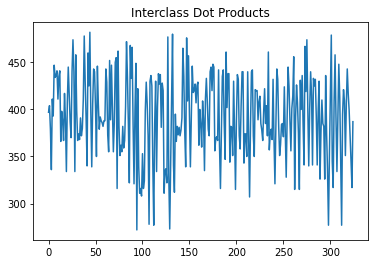

In [17]:
interclass_dot_product(classifier.class_hvs)

# 0.7818 @sp=0.1 M=10
# 0.852 @sp=0.1 M=100
# 0.722 @sp=0.05 M=30
# 0.786 @sp=0.05 M=10
# 0.8 @sp=0.05 M=2

In [18]:
for hv in list(classifier.class_hvs.values()):
    print(np.sum(hv))

475
504
491
504
497
483
490
471
484
478
480
490
477
476
519
496
507
518
485
494
516
504
483
488
507
501


In [22]:
classifier.query(classifier.class_hvs[2])

2

# QUESTIONS

Is the encoded hv similar to all the level and base hypervectors?

In [59]:
sample = feature_encoder.encode(test_class_rows[1][0])

Mean dist: 79.55105348460292


Text(0, 0.5, 'dot product')

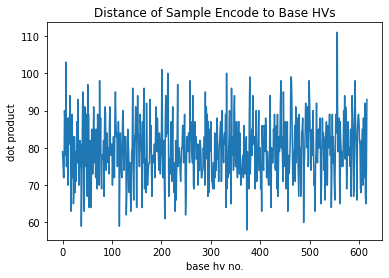

In [61]:
dists = []
for base_hv in feature_encoder.base_hvs:
    dists.append( SparseHDC.dot(base_hv, sample) )

print("Mean dist: {}".format(np.average(np.array(dists))))
plt.plot(dists)
plt.title("Distance of Sample Encode to Base HVs")
plt.xlabel("base hv no.")
plt.ylabel("dot product")

# Normalized distance is ~0.3 for the sample and the base hvs @sp=0.3 M=10
# Normalized distance is ~0.079 for the sample and the base hvs @sp=0.1 M=10

Mean dist: 78.72727272727273


Text(0, 0.5, 'dot product')

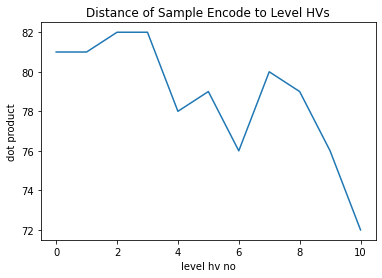

In [62]:
dists = []
for level_hv in list(feature_encoder.cim.values()):
    dists.append( SparseHDC.dot(level_hv, sample) )

print("Mean dist: {}".format(np.average(np.array(dists))))
plt.plot(dists)
plt.title("Distance of Sample Encode to Level HVs")
plt.xlabel("level hv no")
plt.ylabel("dot product")

# Normalized distance is ~0.3 for the sample and the level hvs @sp=0.3, M=10
# Normalized distance is ~0.1 for the sample and the level hvs @sp=0.1  M=10

Does binding preserve the sparsity?

In [63]:
np.sum( feature_encoder.binder.bind( feature_encoder.base_hvs[0], 0, feature_encoder.cim[-1], 0) )

# Binding reduces the sparsity from ~0.3 to ~0.1
# Binding reduces the sparsity from ~0.1 to ~0.01

88

Does this encoding encode different classes to different vectors?

In [64]:
A = feature_encoder.encode(test_class_rows[1][0])
B = feature_encoder.encode(test_class_rows[2][0])
SparseHDC.dot(A,B)

# 0.763 @sp=0.3 M=10
# 0.477 @sp=0.1 M=10

477